# Wikipedia Trends Forecaster

In this project, we study Wikipedia pageview data with the goal of forecasting future traffic trends across different categories of pages. We begin by extracting raw daily pageviews and aggregating them into weekly totals. This preprocessing step both reduces the dataset size and mitigates the strong weekly seasonality patterns that are characteristic of Wikipedia traffic.

Our first approach uses Prophet, a popular time series forecasting tool designed to capture trend and seasonality. Prophet provides quick, interpretable forecasts, and we will explore both the scenarios where it captures category trends well and those where it fails to adapt to sudden changes.

To improve predictive accuracy, we then ccreate a basic dense neural network (NN) capable of forecasting the time series. This model takes as input a fixed-length sliding window of past weekly pageviews and produces a fixed-length forecast of future values. Unlike Prophet, the NN learns directly from historical dynamics across multiple categories, allowing it to predict more complex behaviors. We train the model jointly on a broad set of Wikipedia categories, and then apply it to forecast individual categories beyond the training window.

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import utils, prop, nn

## Data extraction

We begin by extracting ten years of daily pageview data for a selected set of categories, together with their depth-one subcategories. The extracted data is stored in parquet format, organized by category, year, and article title. To simplify later access, we define a glob-style path that matches this directory structure and allows us to load all relevant files at once. Since this data extraction step only needs to be performed once, the corresponding code is commented out to avoid unnecessary reruns.

In [2]:
categories = [
    "Artificial intelligence",
    "Climate change",
    "Quantum computing",
    "Astrophysics",
    "Philosophy",
    "Economics",
    "Genetics"
]

project = "en.wikipedia.org"
subcat_depth = 1
start = "2015-01-01"
end = "2025-08-31"
out_dir = os.path.abspath(os.path.join("..", "data"))
os.makedirs(out_dir, exist_ok = True)

# for cat in categories:
#     titles = utils.list_category_pages(cat, subcat_depth = 0)["title"].tolist()
#     utils.fetch_daily_pageviews(titles = titles, start = start, end = end, out_type = "parquet", out_dir = out_dir, category_name = cat)

glob_path = os.path.join(out_dir, "category=*", "year=*", "title=*.parquet").replace("\\", "/")

To visualize the data, we plot the trends for these categories over the past five years:

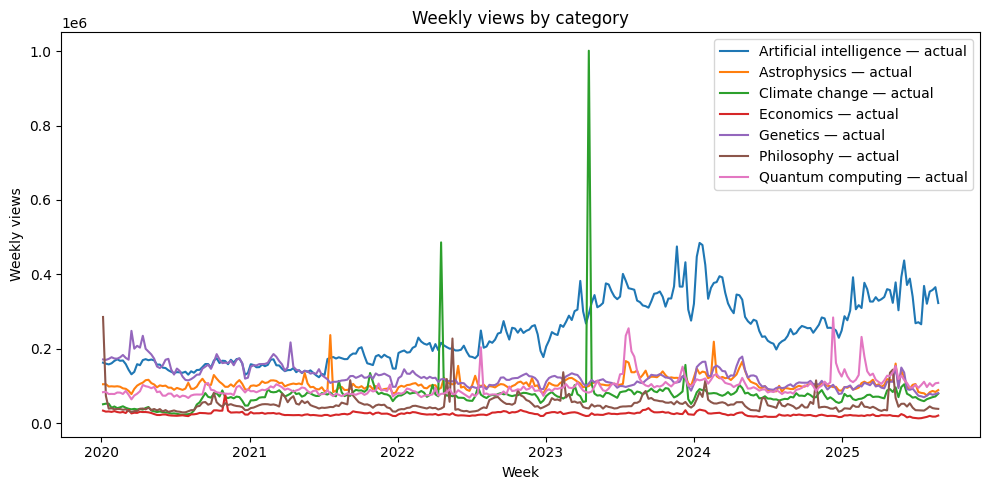

In [3]:
data = utils.to_weekly_parquet(glob_path, start = "2020-01-01")
utils.plot(data)

## Prophet

Prophet is a forecasting tool built to handle time series data with trends and seasonality. It works well out of the box, needs little tuning, and runs fast even on long histories. Because of this, it’s often used for large-scale forecasting. For example, we can use it to project the overall growth in interest in Quantum computing:

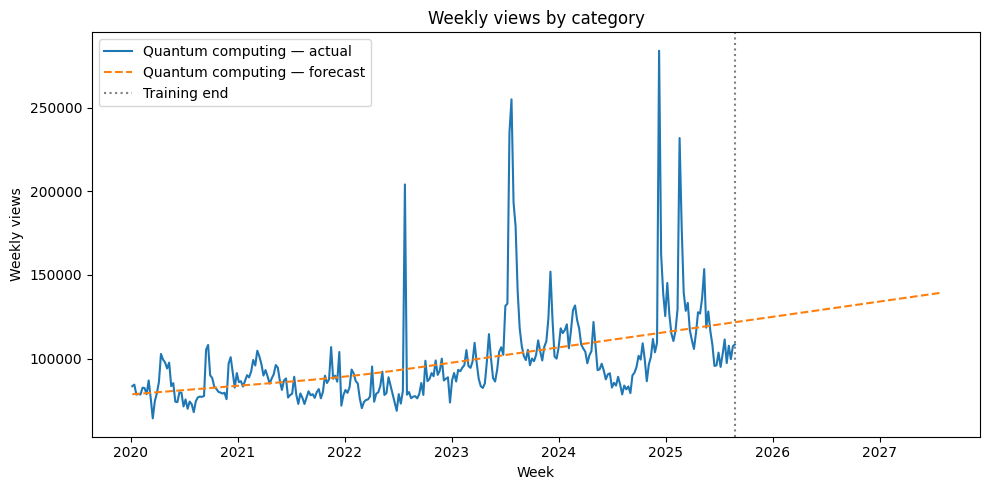

In [4]:
data = utils.to_weekly_parquet(glob_path, start = "2020-01-01")
forecast = prop.forecast(data = data, horizon = 100, categories = ["Quantum computing"])
utils.plot(data = data, forecast = forecast, categories = ["Quantum computing"], train_end = "2025-08-31")

Here, Prophet captures the broad upward trend but misses the sharp spikes and dips in the actual series. That’s fine for coarse, long-term projections, but it can backfire when finer timing matters. For example, it fails to anticipate the secondary spike in Artificial intelligence pageviews that follows the 2024 dip.

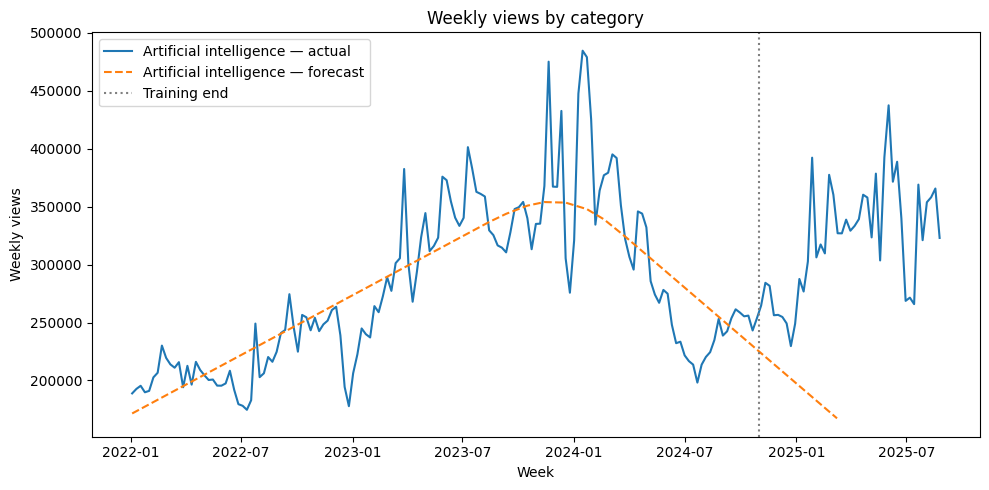

In [6]:
train = utils.to_weekly_parquet(glob_path, start = "2022-01-01", end = "2024-11-01")
data = utils.to_weekly_parquet(glob_path, start = "2022-01-01")
forecast = prop.forecast(data = train, horizon = 20, categories = ["Artificial Intelligence"])
utils.plot(data = data, forecast = forecast, categories = ["Artificial Intelligence"], train_end = "2024-11-01")

## Neural Network

To make finer-scale predictions, we train a straightforward feed-forward neural network on all extracted Wikipedia pageview data from 2015-01-01 up to the start of the forecast region. The forecast region itself is deliberately excluded from training, ensuring the model has no prior knowledge of the data it is later asked to predict.

The network is trained using a Gaussian negative log-likelihood (NLL) loss, and its performance is monitored with root mean squared error (RMSE) computed on the log-delta scale for both training and validation sets. Tracking RMSE in this way avoids numerical issues that arise from raw likelihood values becoming vanishingly small.

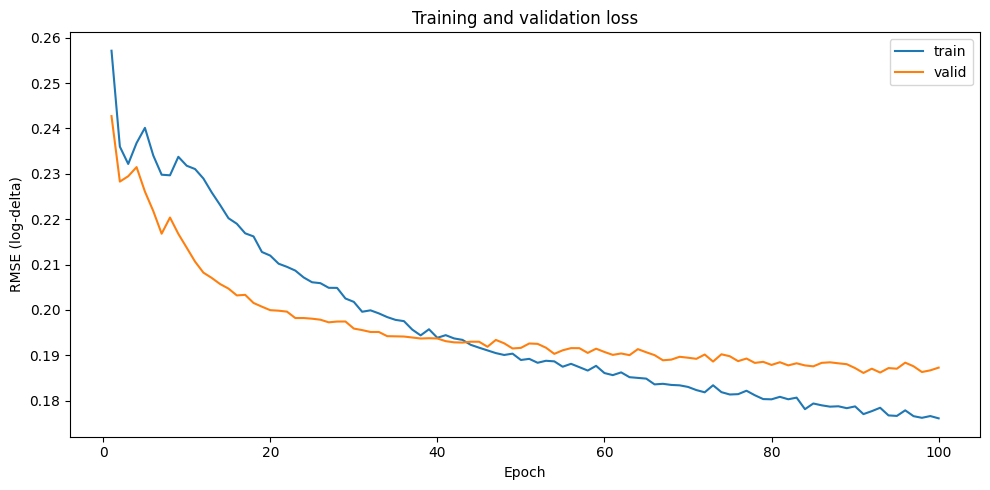

In [3]:
train = utils.to_weekly_parquet(glob_path, end = "2024-11-01")
data = utils.to_weekly_parquet(glob_path, start = "2022-01-01")

window = 60
horizon = 20

X, y = nn.create_dataset(train, window = window, horizon = horizon)
train_loader, valid_loader = nn.prepare_dataloaders(sequences = X, targets = y, batch_size = 256, val_ratio = 0.2, shuffle = True)

model = nn.ReturnForecaster(window = window, horizon = horizon, hidden_sizes = (128, 128), dropout_rate = 0.1)
model, history = nn.train_model(model = model, train_loader = train_loader, valid_loader = valid_loader, epochs = 100, lr = 1e-3)

nn.plot_training_history(history)

Unlike Prophet, the NN is able to capture both the overall upward trend and the smaller fluctuations present in the data:

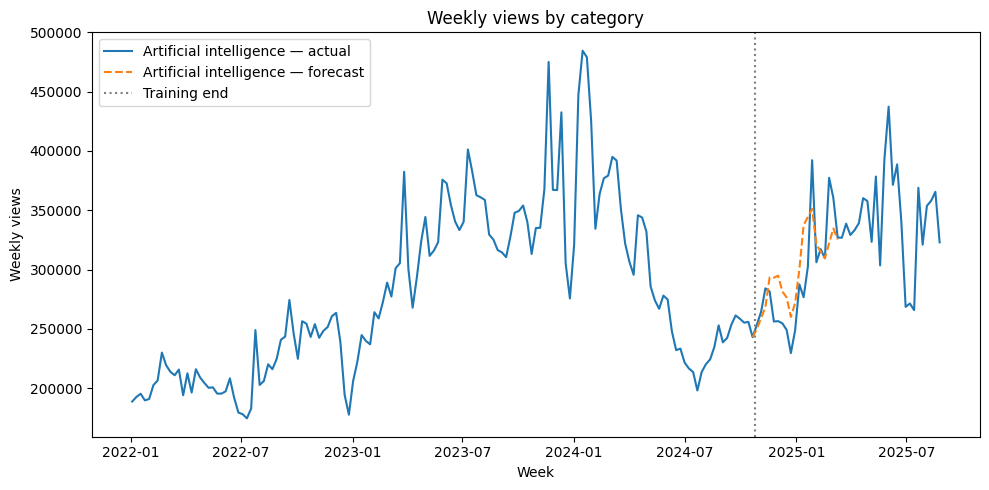

In [24]:
forecast = nn.forecast(data = train, model = model, horizon = horizon, categories = ["Artificial Intelligence"])
utils.plot(data = data, forecast = forecast, categories = ["Artificial Intelligence"], train_end = "2024-11-01")

Another example of the neural network capturing secondary spikes can be seen in the Economics category during the 2023–2024 period.

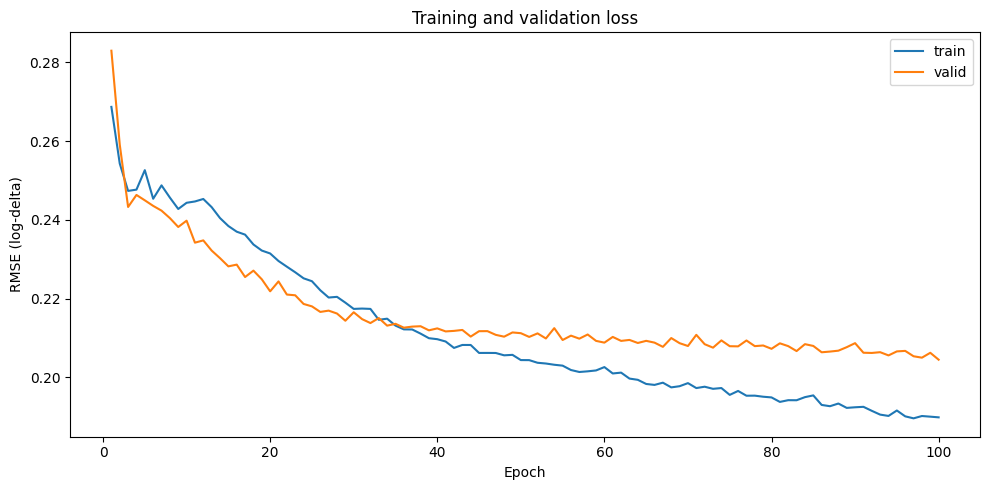

In [4]:
train = utils.to_weekly_parquet(glob_path, end = "2023-09-20")
data = utils.to_weekly_parquet(glob_path, start = "2022-01-01")

window = 80
horizon = 40

X, y = nn.create_dataset(train, window = window, horizon = horizon)
train_loader, valid_loader = nn.prepare_dataloaders(sequences = X, targets = y, batch_size = 256, val_ratio = 0.2, shuffle = True)

model = nn.ReturnForecaster(window = window, horizon = horizon, hidden_sizes = (128, 128), dropout_rate = 0.1)
model, history = nn.train_model(model = model, train_loader = train_loader, valid_loader = valid_loader, epochs = 100, lr = 1e-3)

nn.plot_training_history(history)

Here, the model manages to predict the initial drop, the following secondary spike, and the overall downward trend that follows:

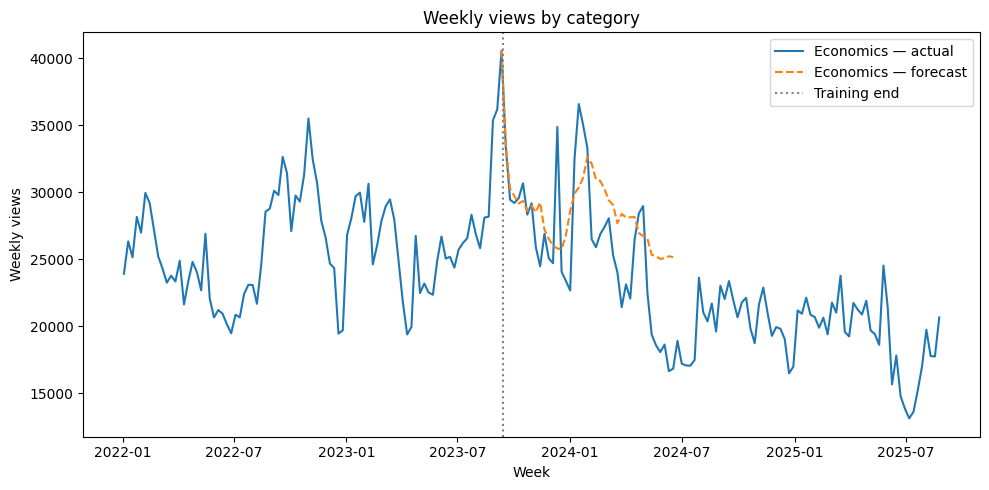

In [58]:
forecast = nn.forecast(data = train, model = model, horizon = horizon, categories = ["Economics"])
utils.plot(data = data, forecast = forecast, categories = ["Economics"], train_end = "2023-09-20")

The NN also performs well for larger-scale forecasts. For instance, it successfully learns and predicts the recurring yearly drop in Genetics pageviews that occurs during the Christmas holidays.

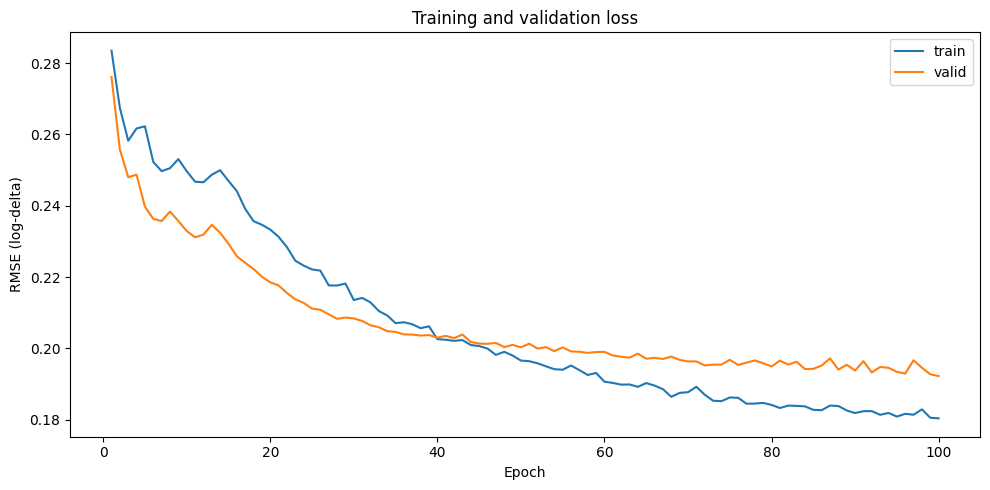

In [5]:
train = utils.to_weekly_parquet(glob_path, end = "2023-01-01")
data = utils.to_weekly_parquet(glob_path, start = "2021-01-01")

window = 120
horizon = 60

X, y = nn.create_dataset(train, window = window, horizon = horizon)
train_loader, valid_loader = nn.prepare_dataloaders(sequences = X, targets = y, batch_size = 256, val_ratio = 0.2, shuffle = True)

model = nn.ReturnForecaster(window = window, horizon = horizon, hidden_sizes = (128, 128), dropout_rate = 0.1)
model, history = nn.train_model(model = model, train_loader = train_loader, valid_loader = valid_loader, epochs = 100, lr = 1e-3)

nn.plot_training_history(history)

During the relatively stable period of 2023, the NN produces a forecast curve that closely tracks the actual pageview patterns:

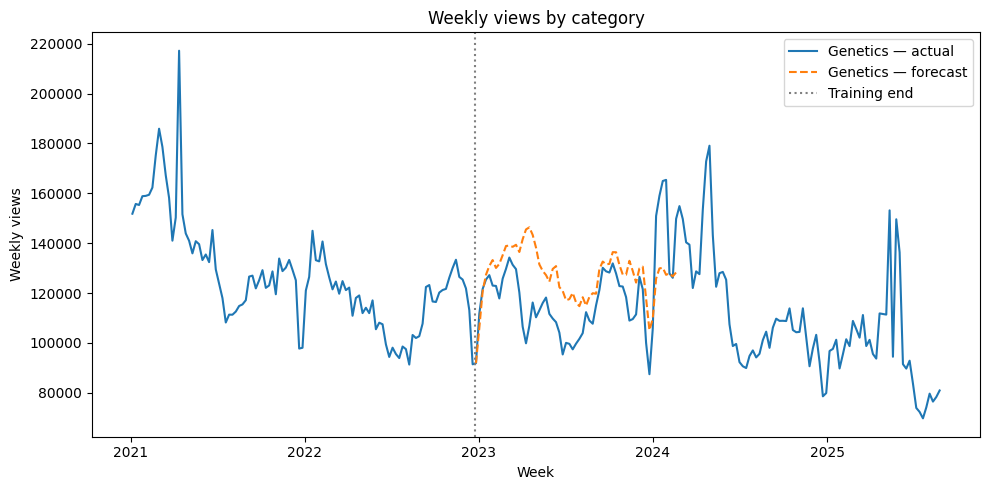

In [6]:
forecast = nn.forecast(data = train, model = model, horizon = horizon, categories = ["Genetics"])
utils.plot(data = data, forecast = forecast, categories = ["Genetics"], train_end = "2023-01-01")

## Conclusions

In this project, we explored Wikipedia pageview data across a range of categories, aggregated daily counts into weekly totals, and used two forecasting approaches: Prophet and a custom neural network. Prophet proved effective at capturing long-term trends and handling large datasets quickly, but often missed sharper short-term fluctuations. The neural network, by contrast, was able to learn finer patterns in the data, including secondary spikes and seasonal drops, making it better suited for detailed forecasting tasks. Together, these results highlight the trade-off between simple, scalable models and more flexible, data-driven ones.